# Project 3: Poisonous mushrooms

In this project, you'll investigate properties of mushrooms. This classic dataset contains over 8000 observations, where each mushroom is described by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. Since all the observations are categorical, I've binarized the feature space. Look at the feature_names below to see all 126 binary names.

You'll start by running PCA to reduce the dimensionality from 126 down to 2 so that you can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). Recall that PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once you've projected the data to 2 dimensions, you'll experiment with clustering using KMeans and density estimation with Gaussian Mixture Models. Finally, you'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [178]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import mixture
from matplotlib.colors import LogNorm
import random as rand
import pandas as pd

Load feature names.

In [8]:
feature_names = []
with open('/Users/ozimmer/Google Drive/berkeley/w207/w207/assignment 3/Data/mushroom.map') as fmap:
    for line in fmap:
        [index, name, junk] = line.split()
        feature_names.append(name)

print 'Loaded feature names:', len(feature_names)

Loaded feature names: 126


Load data. The data is sparse in the input file, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [9]:
X, Y = [], []

with open('/Users/ozimmer/Google Drive/berkeley/w207/w207/assignment 3/Data/mushroom.data') as fdata:
    for line in fdata:
        items = line.split()
        Y.append(int(items.pop(0)))
        x = np.zeros(len(feature_names))
        for item in items:
            feature = int(item.split(':')[0])
            x[feature] = 1
        X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print train_data.shape, test_data.shape

(7000, 126) (1124, 126)


(1) Run Principal Components Analysis on the data. Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 50].

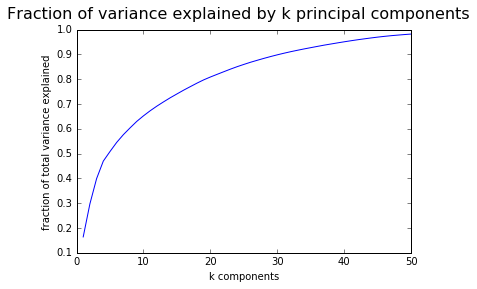

In [10]:
#def P1():
### STUDENT START ###
ratio_variance_explained = []
for k in range(1, 51):
    pca_mod = PCA(n_components = k)
    pca_mod.fit(train_data)
    ratio_variance_explained.append(np.sum(pca_mod.explained_variance_ratio_))

fig = plt.figure()
plt.plot(range(1, 51), ratio_variance_explained, color='blue')
plot_title = 'Fraction of variance explained by k principal components'
fig.suptitle(plot_title, fontsize=16)
plt.xlabel('k components')
plt.ylabel('fraction of total variance explained') 
plt.show()

### STUDENT END ###

#P1()

(2) PCA can be very useful for visualizing data. Project the training data down to 2 dimensions and plot it. Show the positive (poisonous) cases in blue and the negative (non-poisonous) in red. Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html

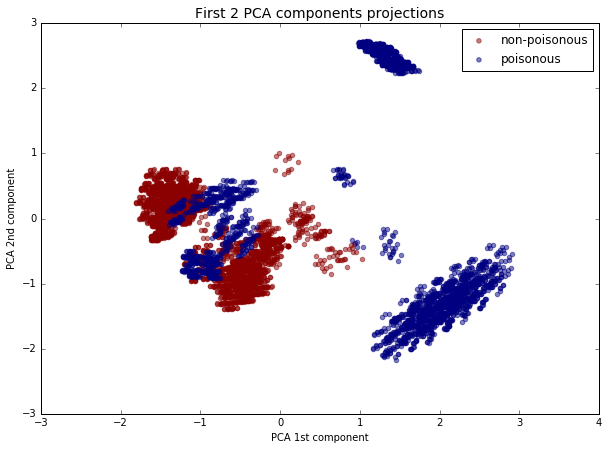

In [167]:
#def P2():
### STUDENT START ###
k = 2
pca_mod = PCA(n_components = k)
pca_components = pca_mod.fit(train_data).transform(train_data)

plt.figure(figsize=(10,7))
lw = 2
colors = ['darkred', 'navy']
for color, i, legend in zip(colors, [0,1], ['non-poisonous', 'poisonous']):
    plt.scatter(pca_components[train_labels == i, 0], pca_components[train_labels == i, 1], 
                alpha=.5, color = color, label = legend)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('First 2 PCA components projections', fontsize=14)
plt.xlabel('PCA 1st component')
plt.ylabel('PCA 2nd component') 
plt.show()

#P2()

(3) Run KMeans with [1,16] clusters over the 2d projected data. Mark each centroid cluster and plot a circle that goes through the most distant point assigned to each cluster.

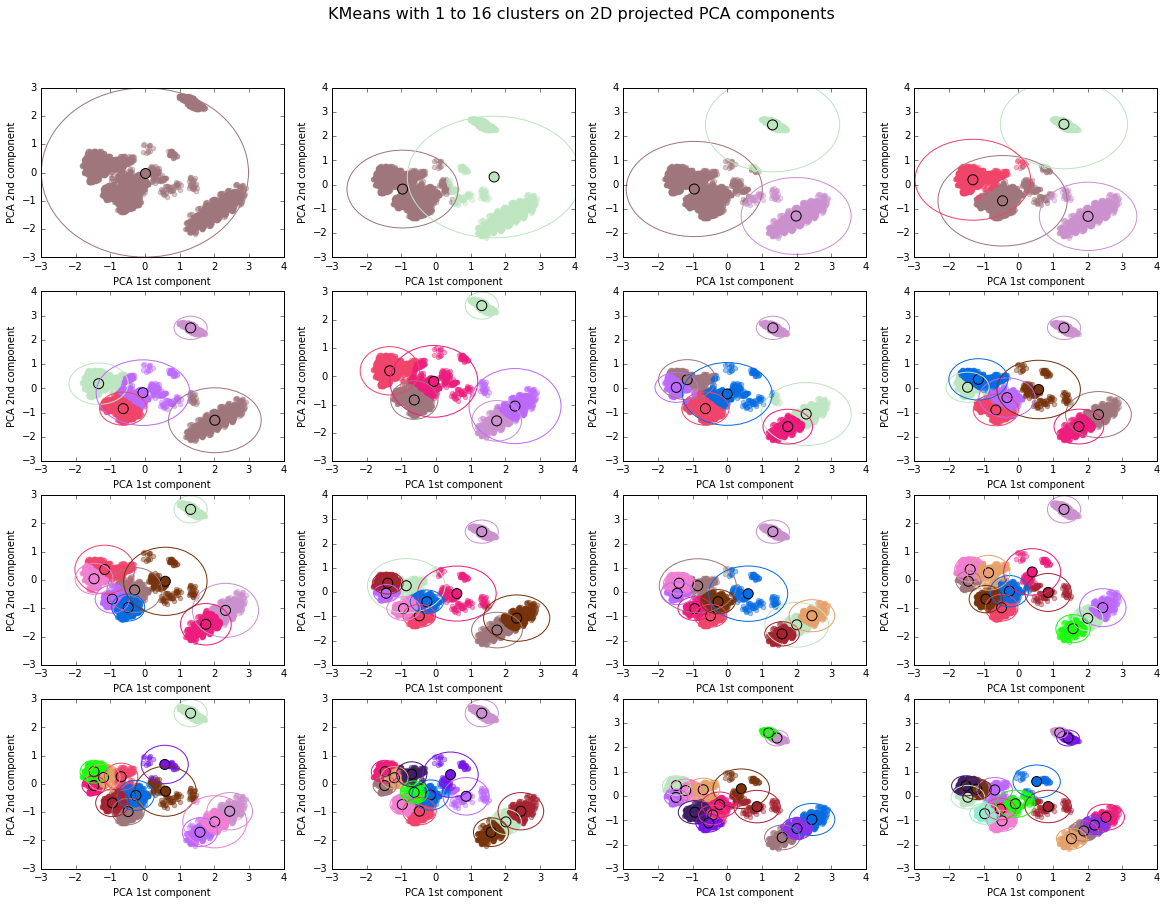

In [18]:
#def P3():
### STUDENT START ###

random.seed(5)

# Define the Euclidian distance
def EuclideanDistance(v1, v2):
    sum = 0.0
    for index in range(len(v1)):
        sum += (v1[index] - v2[index]) ** 2
    return sum ** 0.5

# Get the Kmean cluster object
def GetKMeansClusters(pca_components, cluster):
    km = KMeans (n_clusters = cluster, init='k-means++')
    clstrs = km.fit (pca_components)
    return clstrs

# Get the distance to the most distant point per centroid
def GetDistanceCentroid(pca_components, clstrs, cluster):
    max_distance_centroid = []
    for i in range(0, cluster):
        pca_components_per_label = pca_components[clstrs.labels_ == i]
        distance_centroid = []
        for j in range(0, pca_components_per_label.shape[0]):
            distance_centroid.append(EuclideanDistance(clstrs.cluster_centers_[i], pca_components_per_label[j]))    
        max_distance_centroid.append(np.amax(distance_centroid))
    return max_distance_centroid
    
# Plot the figure
def PlotKmeansClusters(pca_components, clstrs, max_distance_centroid, cluster):
    fig = plt.gcf()
    ax = fig.gca()
    for color, i, legend in zip(colors[:cluster], range(0, cluster), range(0, cluster)):
        plt.scatter(pca_components[clstrs.labels_ == i, 0], pca_components[clstrs.labels_ == i, 1], 
                    alpha=.4, color = color, label = legend)
        circle = plt.Circle((clstrs.cluster_centers_[i,0], clstrs.cluster_centers_[i,1]), max_distance_centroid[i], 
                        color=color, fill=False)
        ax.add_artist(circle)
    plt.scatter (clstrs.cluster_centers_[:,0], clstrs.cluster_centers_[:,1], c = colors[:cluster], s = 100)
    plt.xlabel('PCA 1st component')
    plt.ylabel('PCA 2nd component') 

# Generate a list of 16 colors
colors = []
for i in range(16):
    colors.append('#%06X' % rand.randint(0, 0xFFFFFF))

# Loop from 1 to 16 clusters
plt.figure(figsize=(20,14))
plt.suptitle('KMeans with 1 to 16 clusters on 2D projected PCA components', fontsize=16)

for cluster in range(1,17):
    clstrs = GetKMeansClusters(pca_components, cluster)
    max_distance_centroid = GetDistanceCentroid(pca_components, clstrs, cluster)
    lw = 2
    plt.subplot(4, 4, cluster)
    PlotKmeansClusters(pca_components, clstrs, max_distance_centroid, cluster)
plt.show()

### STUDENT END ###

#P3()

(4) Fit a Gaussian Mixture Model for the positive examples in your 2d projected data. Plot the estimated density contours as shown here: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py. Vary the number of mixture components from 1-4 and the covariance matrix type ('spherical', 'diag', 'tied', 'full').

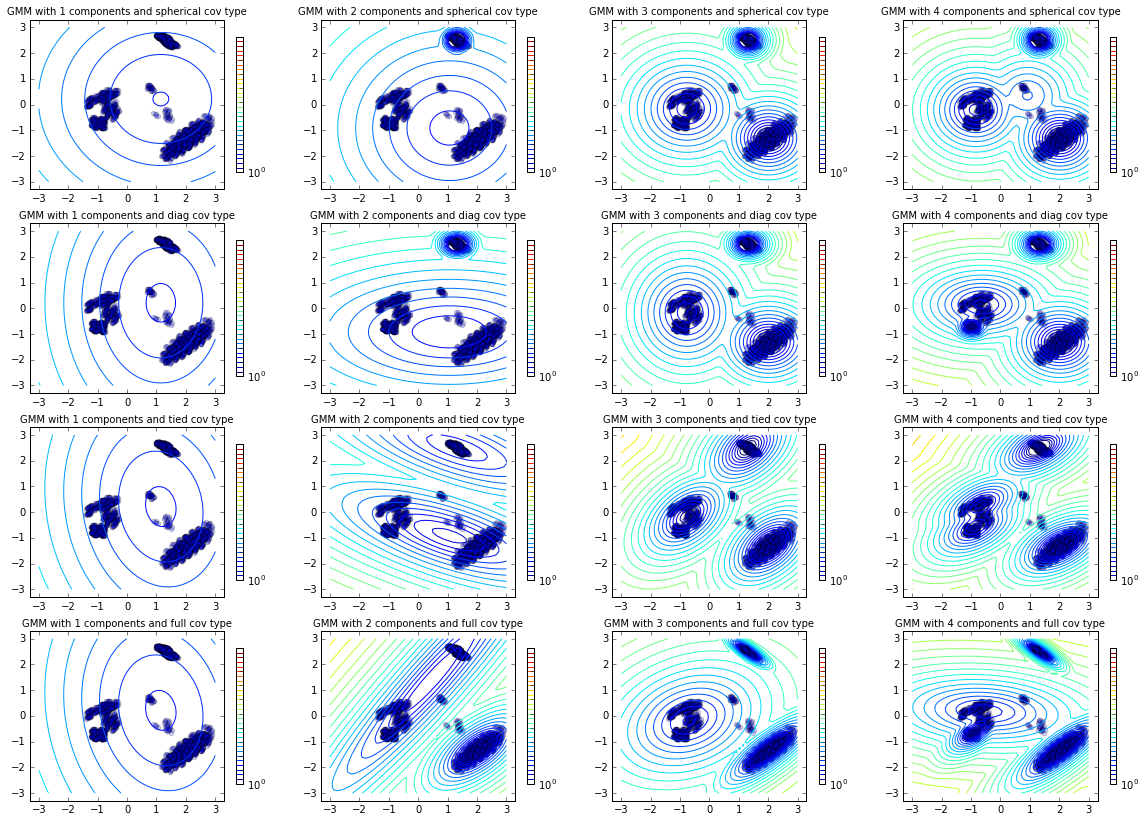

In [55]:
#def P4():
### STUDENT START ###
positive_examples = pca_components[train_labels == 1,:]

# fit & plot a Gaussian Mixture Model
def getGMM(examples, n_components, covariance_type):
    clf = mixture.GaussianMixture(n_components=n_components, covariance_type=covariance_type)
    clf.fit(examples)

    # display predicted scores by the model as a contour plot
    x = np.linspace(-3., 3.)
    y = np.linspace(-3., 3.)
    X, Y = np.meshgrid(x, y)
    XX = np.array([X.ravel(), Y.ravel()]).T
    Z = -clf.score_samples(XX)
    Z = Z.reshape(X.shape)
    CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                     levels=np.logspace(0, 3, 30))
    CB = plt.colorbar(CS, shrink=0.8, extend='both')
    plt.scatter(examples[:, 0], examples[:, 1], alpha=.2)
    plt.title('GMM with ' + str(n_components) + ' components and ' + covariance_type + ' cov type', fontsize = 10)
    plt.axis('tight')

# Loop on 1 to 4 components and the covariance matrix type
plt.figure(figsize=(20,14))
for cov, i in zip(['spherical', 'diag', 'tied', 'full'], [0, 4, 8, 12]):
    for n in range(1, 5):
        plt.subplot(4, 4, n + i)
        getGMM(positive_examples, n_components = n, covariance_type = cov)
plt.show()
### STUDENT END ###
#P4()

(5) Fit two 4-component full covariance GMMs, one for the positive examples and one for the negative examples in your 2d projected data. Predict the test examples by choosing the label for which the model gives a larger probability (use GMM.score). What is the accuracy?

Test accuracy: 95.02


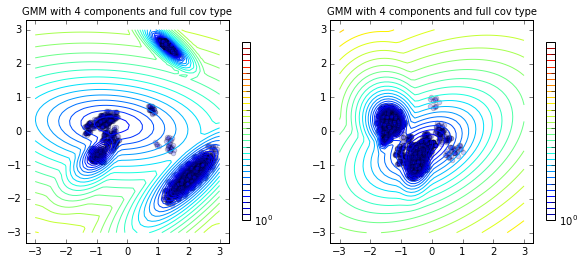

In [174]:
#def P5():
### STUDENT START ###
k = 2
pca_mod = PCA(n_components = k)
pca_components = pca_mod.fit(train_data).transform(train_data)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
positive_examples = pca_components[train_labels == 1,:]
getGMM(positive_examples, n_components = 4, covariance_type = 'full')

plt.subplot(1,2,2)
negative_examples = pca_components[train_labels == 0,:]
getGMM(negative_examples, n_components = 4, covariance_type = 'full')

def GetlikelihoodDensity(examples, pca_components_test, n_components, covariance_type):
    clf = mixture.GaussianMixture(n_components=n_components, covariance_type=covariance_type)
    clf.fit(examples)
    predicted_labels = clf.score_samples(pca_components_test)
    return predicted_labels

# Transform to get PCA components on the test_data & compare likelihood to get labels
def GetaccuracyGMM(test_data, positive_examples, negative_examples, n_components, covariance_type):
    pca_components_test = pca_mod.transform(test_data)
    positive_likelihood = GetlikelihoodDensity(positive_examples, pca_components_test, n_components, covariance_type)
    negative_likelihood = GetlikelihoodDensity(negative_examples, pca_components_test, n_components, covariance_type)
    predicted_label = []
    for i in range(0, positive_likelihood.shape[0]):
        if positive_likelihood[i] > negative_likelihood[i]:
            predicted_label.append(1)
        else:
            predicted_label.append(0)
    test_accuracy = np.mean(test_labels == predicted_label) * 100
    return test_accuracy

print 'Test accuracy: %.2f' %GetaccuracyGMM(test_data, positive_examples, negative_examples, 4, 'full')
### STUDENT END ###

#P5()

(6) Ideally, we'd like a model that gives the best accuracy with the fewest parameters. Run a series of experiments to find the model that gives the best accuracy with no more than 50 parameters. For example, with 3 PCA components and 2-component diagonal covariance GMMs, you'd have:

( (3 mean vector + 3 covariance matrix) x 2 components ) x 2 classes = 24 parameters

You should vary the number of PCA components, the number of GMM components, and the covariance type.

In [179]:
#def P6():
### STUDENT START ###
df_accuracies_per_parameters = pd.DataFrame()
for k_pca in range(1, 8):
    for n_components in range(1, 5):
        for covariance_type in ['spherical', 'diag', 'tied', 'full']:
            #Calculate the # of parameters according to the covariance matrix
            if covariance_type == 'spherical':
                covariance_parameters = 1 * n_components
            if covariance_type == 'diag':
                covariance_parameters = k_pca * n_components
            if covariance_type == 'full':
                covariance_parameters = (k_pca + (k_pca * (k_pca - 1)) / 2) * n_components
            if covariance_type == 'tied':
                covariance_parameters = (k_pca + (k_pca * (k_pca - 1)) / 2) * 1
            parameters = (k_pca * n_components + covariance_parameters) * 2
            # Less than 50 parameters then get the accuracy                          
            if parameters <= 50: 
                pca_mod = PCA(n_components = k_pca)
                pca_components = pca_mod.fit(train_data).transform(train_data)
                positive_examples = pca_components[train_labels == 1,:]
                negative_examples = pca_components[train_labels == 0,:]
                accuracy = GetaccuracyGMM(test_data, positive_examples, negative_examples, n_components, covariance_type)
                df_accuracies_per_parameters = df_accuracies_per_parameters.append({'parameters': parameters,
                                                                                    'k_pca': k_pca,
                                                                                    'n_components': n_components,
                                                                                    'covariance_type':covariance_type,
                                                                                    'accuracy':accuracy
                                                                                   },
                                                                                   ignore_index=True)
df_accuracies_per_parameters.sort_values('accuracy', ascending=0).head(10)                

### STUDENT END ###

#P6()

,accuracy,covariance_type,k_pca,n_components,parameters
74,97.330961,spherical,7.0,3.0,48.0
55,96.975089,tied,4.0,3.0,44.0
65,96.797153,spherical,5.0,4.0,48.0
70,96.797153,spherical,6.0,3.0,42.0
64,96.619217,spherical,5.0,3.0,36.0
63,96.174377,tied,5.0,2.0,50.0
43,95.907473,spherical,3.0,4.0,32.0
56,95.729537,spherical,4.0,4.0,40.0
73,95.551601,spherical,7.0,2.0,32.0
31,95.017794,full,2.0,4.0,40.0
